In [9]:
using JuMP, Gurobi

    dims = 3
    k = 4              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(dims,k)    # vector of waypoint locations

    T[1] = 1
    T[2] = 20
    T[3] = 50
    T[4] = 60

    # define waypoints
    xw = [ 1   4   6   1
           1   3   0   1 
           1   2   2   1 ];

In [10]:
mass = 10
g = [0 0 -9.8]';

3×1 Array{Float64,2}:
  0.0
  0.0
 -9.8

In [42]:
    m = Model(solver = GurobiSolver(OutputFlag=0))
    
    @variable(m, x[1:dims,1:T[k]])  # resulting position
    @variable(m, v[1:dims,1:T[k]])  # resulting velocity
    @variable(m, u[1:dims,1:T[k]])  # thruster input

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== zeros(dims,1)')

    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[:,t+1] .== v[:,t] + u[:,t] + g)
        @constraint(m, u[3,t] == g[3])
    end

    # hit all the waypoints
    for i in [1 k]
        @constraint(m, x[:,T[i]] .== xw[:,i])
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    λ = 100
    @objective(m, Min, sum(u.^2) + λ*sum( (x[:,T[2:k]]-xw[:,2:k]).^2  ) )
    solve(m)

:InfeasibleOrUnbounded

In [38]:
xopt = getvalue(x)

3×60 Array{Float64,2}:
 1.0  1.0  1.02433  1.0718   1.14121  1.23136  …   2.13907    1.57171   1.0
 1.0  1.0  1.02919  1.08448  1.16279  1.26102      0.720522   0.859019  1.0
 1.0  1.0  1.22757  1.64359  2.20892  2.88444     43.8218    26.7519    1.0

In [39]:
uopt = getvalue(u)

3×60 Array{Float64,2}:
  0.0243338  0.0231355  0.0219373  0.0207391  …  -0.0043463   -0.0  -0.0
  0.0291896  0.0261024  0.0230153  0.0199281      0.00248394  -0.0  -0.0
 10.0276     9.98844    9.94932    9.91019        1.11814     -0.0  -0.0

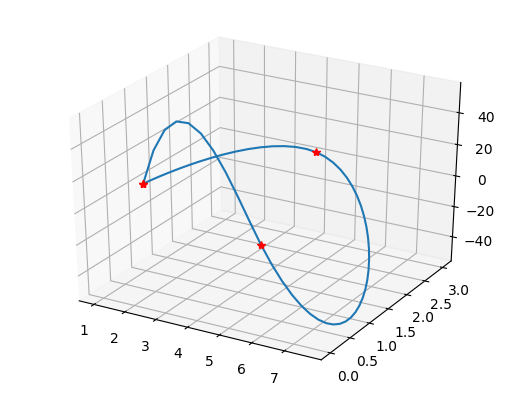

In [40]:
using PyPlot
plot3D(xopt[1,:],xopt[2,:],xopt[3,:])
plot3D(xw[1,:],xw[2,:],xw[3,:],"r*");